In [1]:
#for j in $(seq 3 4); do for i in $(seq 1 20); do python main --seed $((20 * j + $i))&done;done;

In [2]:
import bempp.api
import numpy as np

import sys
sys.path.append('../../')
from decimal import *

import bemppUQ
from bemppUQ.operators.maxwell import assemble_operators, evaluate_far_field, evaluate_far_field_sd

bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
bempp.api.global_parameters.hmat.eps = 1E-4


from bemppUQ.shapes import reentrant_cube_exterior

def function(x, y, i, j):
    zx = 0
    zy = 0
    if i == 0:
        zx = np.sin(x * np.pi * 2)
    if i == 1:
        if x <= 0.25:
            zx = np.sin(x * np.pi * 4)
    if i == 2:
        if x > 0.25:
            zx = -np.sin(x * np.pi * 4)
    if i == 3:
        if x <= 0.5 / 3.:
            zx = np.sin(x * np.pi * 6)
    if i == 4:
        if x > 0.5 / 3. and x <= 1 / 3.:
            zx = -np.sin(x * np.pi * 6)
    if i ==5:
        if x > 1/3.:
            zx = np.sin(x * np.pi * 6)

    if j == 0:
        zy = np.sin(y * np.pi * 2)

    if j == 1:
        if y <= 0.25:
            zy = np.sin(y * np.pi * 4)

    if j == 2:
        if y > 0.25:
            zy = -np.sin(y * np.pi * 4)
    
    if j == 3:
        if y <= 0.5 / 3.:
            zy = np.sin(y * np.pi * 6)

    if j == 4:
        if y > 0.5 / 3. and y <= 1 / 3.:
            zy = -np.sin(y * np.pi * 6)
    if j == 5:
        if y > 1/3.:
            zy = np.sin(y * np.pi * 6)

    return zx * zy


# Def random:

def Phiz(point, n, domain_index, result):
    x, y, z = point

    res = 0j
    if z == 0.5 and (x <= 0.5) and (y <= 0.5):
        for ii in range(6):
            for jj in range(6):
                res += Random[ii,jj] * function(x, y, ii,jj)	
    result[0] = res



def perturbate(grid, t, kappa_pert=None):
    P1 = bempp.api.function_space(grid, 'B-P', 1)
    grid_funz = bempp.api.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bempp.api.grid_from_element_data(vertices, elements)



def get_base_grid(h):

    gr0 = bempp.api.shapes.reentrant_cube(h=h, refinement_factor=1) 
    elements0 = list(gr0.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    tol = h / 10.
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2]) - z) < tol:
            gr0.mark(el0)
    gr1 = gr0.refine()


    elements0 = list(gr1.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2])-z) < tol:
            gr1.mark(el0)

    base_grid = gr1.refine()
    return base_grid



config = bemppUQ.config.set_case('A')
precision = 40

h = 2.0 * np.pi / (precision * config["k_int"])

base_grid = bempp.api.shapes.reentrant_cube(h=h, refinement_factor=1)  #get_base_grid(h=h) 
N = 2 * base_grid.leaf_view.entity_count(1)
print(N)
transmission_operators = assemble_operators(base_grid, config)
Umean, solution = evaluate_far_field(transmission_operators, config)


#far_field_p, sol_p = evaluate_far_field_sd(base_grid, transmission_operators, config, solution, grid_fun)

nrank = 1
grid_funs = []
for ii in range(nrank):
    for jj in range(nrank):
        def fun(point, n, domain_index, result):
            x, y, z = point

            res = 0j
            if z == 0.5 and (x <= 0.5) and (y <= 0.5):
                res += function(x, y, ii,jj)
            result[0] = res
            
        space = bempp.api.function_space(base_grid, 'B-P', 1)
        grid_fun = bempp.api.GridFunction(space, fun= fun)
        grid_funs.append(grid_fun)
        
    

32904
iteration - 1 || residual - 0.138087170495 10.026626586914062
iteration - 2 || residual - 0.0234425098238 5.217157602310181
iteration - 3 || residual - 0.00366142936265 5.630201578140259
iteration - 4 || residual - 0.000597816373938 4.998201370239258
iteration - 5 || residual - 0.000109710331155 4.946171998977661
iteration - 6 || residual - 1.91284419205e-05 5.127779006958008
iteration - 7 || residual - 2.66320661204e-06 0.008562326431274414


In [3]:
result = evaluate_far_field_sd(base_grid, transmission_operators, config, solution, grid_funs, solve = True)


0
iteration - 1 || residual - 0.0711331426368 10.18783164024353
iteration - 2 || residual - 0.0096959674736 4.888858318328857
iteration - 3 || residual - 0.0015354477493 4.892445087432861
iteration - 4 || residual - 0.000281921731738 4.842792510986328
iteration - 5 || residual - 4.04057751821e-05 4.925205230712891
iteration - 6 || residual - 6.40203448114e-06 0.0051538944244384766


In [4]:
n = config['number_of_angles']

Sigma = np.zeros((n, n), dtype=np.complex128)
k = 0
for ii in range(nrank):
    for jj in range(nrank):
        #ff = np.sum(result[k], axis=0)
        ff = result[k][0]
        Sigma += 1/3. * bemppUQ.utils.login.tensorize(ff,ff)
        k += 1
        
t = .05
Uvars = t ** 2 * Sigma.diagonal()
Umeans = Umean[0]#np.sum(Umean, axis=0)


/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


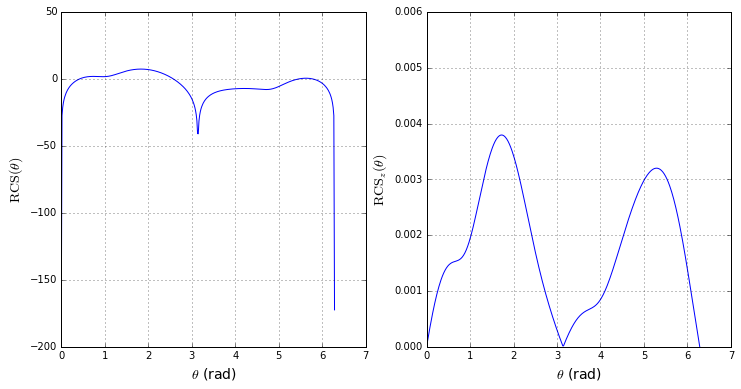

In [6]:
from matplotlib import pyplot as plt

angles = config['angles']

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,6))

cs = 10 * np.log10(4 * np.pi * np.abs(Umeans)**2)

ax1.plot(angles, cs)


y = np.sqrt(np.abs(Uvars))
ax2.plot(angles, y)


ax2.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax2.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)


ax1.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax1.set_ylabel(r'$\mathrm{RCS}(\theta)$', fontsize=14)

ax1.legend()
ax1.grid()

ax2.legend()
ax2.grid()
ax2.set_ylim(0, 0.006)

plt.show(block=False)
